# Initial experiments

**General idea:** Expand on `00-exploration.ipynb` with further experiments on the `rls-species-100-min-images-4` dataset, with the goals of:

1. Estimating what accuracy is achievable on this dataset.
2. Becoming more comfortable with fast.ai and understanding what goes on under the hood.
3. Using MLflow tracking to increase reproducibility and order when running experiments.

**Assumption:** The RLS dataset was created with the following command (i.e., using the 2021-07-17 dump and images).

```bash
$ python manage.py create-rls-species-dataset \
    --m1-csv-path ~/projects/fish-id/data/dump-20210717/m1.csv \
    --image-dir ~/projects/yanirs.github.io/tools/rls/img \
    --output-dir data/rls-species-100-min-images-4/ \
    --num-species 100 \
    --min-images-per-species 4
```

# TODO: When it's time to optimise the model

* Look at the best model and where it fails &ndash; try to understand the failure points on the images and inside the model rather than try more things blindly
* Follow the inline TODOs

In [4]:
import functools
import gc

from fastai.vision.all import *
import mlflow

import experiments

## One-off MLflow setup

* Using sqlite because flat files take up way too much space (about 60KB per run).
* Setting the registry URI is needed to avoid nesting under the `notebooks/`.
* It seems reasonable to set a single experiment with many runs, as all the results that use the same dataset and splits are comparable. [Comparing results across experiments is unsupported](https://github.com/mlflow/mlflow/issues/1414).
* Nested runs show up nicely in the UI.
* Can run the UI with `mlflow ui --backend-store-uri sqlite:////home/yanir/projects/deep-fish/mlruns.db`.

In [2]:
mlflow.set_tracking_uri('sqlite:////home/yanir/projects/deep-fish/mlruns.db')
mlflow.set_registry_uri('file:///home/yanir/projects/deep-fish/mlruns')
mlflow.set_experiment('initial-rls-species-100-min-images-4')

## Clear GPU memory

Can be useful to avoid a kernel restart.

In [3]:
gc.collect()
torch.cuda.empty_cache()

## Replicating the initial exploration as a start

In [6]:
create_reproducible_learner = functools.partial(
    experiments.create_reproducible_learner,
    dataset_path=Path('/home/yanir/projects/deep-fish/data/rls-species-100-min-images-4')
)

Found 559 items
2 datasets of sizes 448,111
Setting up Pipeline: PILBase.create
Setting up Pipeline: create_reproducible_learner.<locals>.<lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: RandomResizedCrop -- {'size': (224, 224), 'min_scale': 0.5, 'ratio': (0.75, 1.3333333333333333), 'resamples': (2, 0), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}


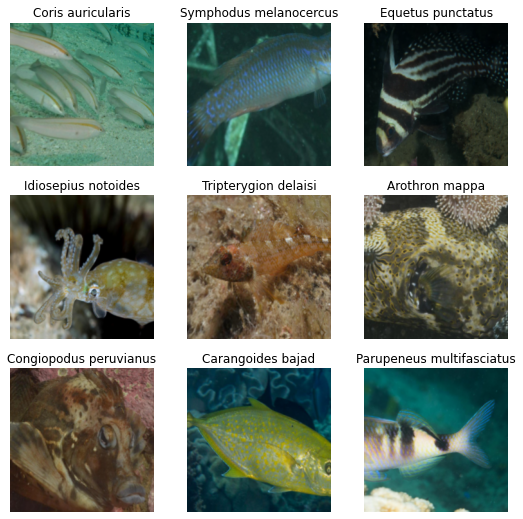

In [7]:
create_reproducible_learner(resnet18, dls_kwargs=dict(verbose=True)).dls.show_batch()

In [8]:
with mlflow.start_run(run_name='initial'):
    learner = create_reproducible_learner(resnet18)
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    learner.fine_tune(20)
    mlflow.log_metrics(dict(zip(learner.recorder.metric_names[1:-1], learner.recorder.log[1:-1])))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,6.321728,5.460814,0.027027,0.054054,00:06


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,5.659076,4.826760,0.036036,0.063063,00:06
1,5.375247,4.553122,0.054054,0.126126,00:06
2,5.072414,4.249314,0.108108,0.207207,00:06
3,4.732468,3.873323,0.126126,0.270270,00:06
4,4.302080,3.545094,0.225225,0.387387,00:06
5,3.836992,3.246705,0.252252,0.441441,00:06
6,3.403827,3.035172,0.288288,0.450450,00:06
7,2.982160,2.793263,0.351351,0.549550,00:06
8,2.634316,2.634649,0.378378,0.585586,00:06
9,2.309923,2.551351,0.387387,0.585586,00:07


In [7]:
with mlflow.start_run(run_name='initial-more-fine-tuning'):
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    mlflow.log_param('start_learner', 'initial')
    learner.fine_tune(100)
    mlflow.log_metrics(dict(zip(learner.recorder.metric_names[1:-1], learner.recorder.log[1:-1])))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.320133,2.282902,0.459459,0.684685,00:05


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.311522,2.253940,0.468468,0.684685,00:06
1,0.296845,2.246810,0.441441,0.675676,00:06
2,0.262586,2.248903,0.459459,0.639640,00:06
3,0.251974,2.224840,0.441441,0.675676,00:06
4,0.250413,2.201876,0.450450,0.675676,00:06
5,0.236786,2.181631,0.450450,0.684685,00:06
6,0.225666,2.167226,0.468468,0.693694,00:06
7,0.215306,2.151812,0.468468,0.702703,00:07
8,0.198303,2.145986,0.468468,0.702703,00:07
9,0.188836,2.124753,0.459459,0.720721,00:06


## Attempting ideas from the Image Classification notebooks (5-7)

Link: https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb

* Learning rate finder doesn't seem as amazing as it's presented: Each iteration is costly, and it doesn't improve on plain old fine-tune. This may be a function of the number of iterations, though.
* **TODO**: Try going without the fine_tune() function
* **TODO**: Try fp16() &ndash; tried but got immediate `NaN`s; needs more work
* **TODO**: Read more carefully to see if there's anything else worth trying

Link: https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

* **TODO**: Try switching to multi-cat

Link: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb

* Normalisation doesn't need to be added because the model is pretrained and it's handled by `cnn_learner()`
* TTA is great! Already getting to a level where performance is good enough for practical use (assuming it generalises to the full species dataset)
* XResnet with many epochs (and read [the XResnet paper](https://arxiv.org/pdf/1812.01187.pdf)) &ndash; trained on Kaggle for the bigger GPU with underwhelming results. Seems to overfit, which means it may be good for bigger datasets or if I have richer augmentations. However, when compared to Resnet, it's also pretty crappy, which may indicate there's an issue with the pretraining.
* MixUp: Nothing amazing, which is in line with [the XResnet paper](https://arxiv.org/pdf/1812.01187.pdf)
* Label smoothing: Similar to MixUp (nothing amazing, which is to be expected from the XResnet paper)
* **TODO**: More rigoruos MixUp & label smoothing experiments (vary the arguments and be smarter about number of epochs?)
* **TODO**: Get XResnet to work &ndash; is the pretraining bad compared to Resnet?
* **TODO**: Try deeper (X)Resnet with many epochs &ndash; may work well with MixUp and label smoothing, as they seem to over-regularise (high training loss that doesn't go down even after 300 epochs)
* **TODO**: Try progressive resizing
* **TODO**: Try playing with `aug_transforms()` (but understand & visualise the effect of every change) &ndash; may be a promising path since it essentially manipulates the data

### Test-time augmentation (TTA)

In [13]:
with mlflow.start_run(run_name='tta-finetuned-120'):
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    mlflow.log_param('start_learner', 'initial-more-fine-tuning')
    mlflow.log_param('fine_tuned_epochs', 120)
    
    # Test different betas, though it is a bit odd -- I don't see a reason to believe that mixing in
    # non-augmented results would work well.
    best_metrics = None
    for beta in np.arange(0, 1.01, 0.1):
        nested_run_name = f'beta {beta:.1f}'
        with mlflow.start_run(run_name=nested_run_name, nested=True):
            mlflow.log_param('beta', beta)
            mlflow.log_param('use_max', False)
            metrics_with_tta = experiments.get_learner_metrics_with_tta(learner, beta=beta, use_max=False)
            print(f"{nested_run_name} top-3 accuracy: {metrics_with_tta['top_3_accuracy']:.4f}")
            mlflow.log_metrics(metrics_with_tta)
            if best_metrics is None or best_metrics['top_3_accuracy'] < metrics_with_tta['top_3_accuracy']:
                best_metrics = metrics_with_tta
                
    # No need to loop over betas for use_max.
    nested_run_name = 'use_max'
    with mlflow.start_run(run_name=nested_run_name, nested=True):
        mlflow.log_param('beta', None)
        mlflow.log_param('use_max', False)
        metrics_with_tta = experiments.get_learner_metrics_with_tta(learner, beta=None, use_max=True)
        print(f"{nested_run_name} top-3 accuracy: {metrics_with_tta['top_3_accuracy']:.4f}")
        mlflow.log_metrics(metrics_with_tta)
        if best_metrics is None or best_metrics['top_3_accuracy'] < metrics_with_tta['top_3_accuracy']:
            best_metrics = metrics_with_tta
            
    mlflow.log_metrics(best_metrics)

beta 0.0 top-3 accuracy: 0.8288
beta 0.1 top-3 accuracy: 0.8198
beta 0.2 top-3 accuracy: 0.8198
beta 0.3 top-3 accuracy: 0.8108
beta 0.4 top-3 accuracy: 0.8108
beta 0.5 top-3 accuracy: 0.8108
beta 0.6 top-3 accuracy: 0.8108
beta 0.7 top-3 accuracy: 0.7928
beta 0.8 top-3 accuracy: 0.7838
beta 0.9 top-3 accuracy: 0.7748
beta 1.0 top-3 accuracy: 0.7297
use_max top-3 accuracy: 0.7928


### XResNet

Paper: https://arxiv.org/abs/1812.01187 &ndash; probably worth reading & understanding.

**TODO**: [It's not pretrained](https://github.com/fastai/fastai/blob/aeb5317d11d986420fde85fc9749aac1f53eefd6/fastai/vision/models/xresnet.py#L60) &ndash; looks like only XResnet50 is pretrained, which may not work due to memory issues. Tried on Kaggle with underwhelming results.

In [14]:
with mlflow.start_run(run_name='xresnet18'):
    learner = create_reproducible_learner(xresnet18)
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    learner.fine_tune(20)
    mlflow.log_metrics(dict(zip(learner.recorder.metric_names[1:-1], learner.recorder.log[1:-1])))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,6.456749,5.929708,0.018018,0.018018,00:06


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,5.401567,4.928265,0.009009,0.018018,00:08
1,5.203355,4.711619,0.036036,0.153153,00:07
2,5.034019,4.775129,0.099099,0.153153,00:08
3,4.788520,4.809145,0.063063,0.216216,00:08
4,4.546418,5.044315,0.081081,0.243243,00:08
5,4.299155,5.343573,0.081081,0.234234,00:08
6,4.064746,5.333014,0.099099,0.234234,00:08
7,3.859321,5.125330,0.117117,0.252252,00:08
8,3.628855,5.088571,0.144144,0.279279,00:08
9,3.430415,4.684314,0.153153,0.297297,00:08


### Label smoothing

In [15]:
with mlflow.start_run(run_name='label-smoothing-with-tta'):
    learner = create_reproducible_learner(resnet18,
                                          learner_kwargs=dict(loss_func=LabelSmoothingCrossEntropy()))
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    mlflow.log_param('loss_func', 'LabelSmoothingCrossEntropy()')
    mlflow.log_param('tta_note', 'only applied to last iteration')
    
    learner.fine_tune(120)

    mlflow.log_metrics(experiments.get_learner_metrics_with_tta(learner, tta_prefix='tta_', beta=0))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,6.334547,5.504412,0.027027,0.054054,00:05


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,5.744416,4.899011,0.036036,0.063063,00:06
1,5.511707,4.703138,0.045045,0.117117,00:06
2,5.309687,4.562863,0.081081,0.153153,00:06
3,5.138036,4.427818,0.081081,0.171171,00:06
4,4.948752,4.304887,0.126126,0.198198,00:06
5,4.755442,4.170666,0.126126,0.216216,00:06
6,4.588717,4.056203,0.144144,0.252252,00:06
7,4.378577,3.929533,0.180180,0.288288,00:06
8,4.206573,3.815495,0.216216,0.333333,00:07
9,4.006558,3.697082,0.261261,0.360360,00:07


SuggestedLRs(valley=0.00010964782268274575)

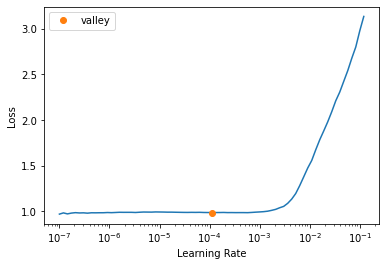

In [16]:
learner.remove_cb(experiments.MLflowCallback)
learner.lr_find()

In [19]:
with mlflow.start_run(run_name='label-smoothing-with-tta-more-fine-tuning'):
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    mlflow.log_param('loss_func', 'LabelSmoothingCrossEntropy()')
    mlflow.log_param('tta_note', 'only applied to last iteration')
    mlflow.log_param('start_learner', 'label-smoothing-with-tta')
    mlflow.log_param('fine_tuned_epochs', 120)

    learner.add_cb(experiments.MLflowCallback())
    
    learner.fine_tune(80, base_lr=0.0001)

    mlflow.log_metrics(experiments.get_learner_metrics_with_tta(learner, tta_prefix='tta_', beta=0))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.980918,2.544078,0.567568,0.729730,00:05


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.976938,2.549347,0.558559,0.729730,00:06
1,0.976446,2.540728,0.549550,0.729730,00:06
2,0.979782,2.547498,0.558559,0.747748,00:06
3,0.978216,2.545907,0.549550,0.747748,00:06
4,0.977030,2.539086,0.558559,0.747748,00:07
5,0.977850,2.535788,0.558559,0.738739,00:07
6,0.981943,2.537251,0.558559,0.747748,00:06
7,0.982132,2.538497,0.576577,0.738739,00:06
8,0.979614,2.537988,0.567568,0.738739,00:06
9,0.978611,2.535806,0.558559,0.729730,00:07


### Learning rate finder

* Conclusion: Slide or valley rule work well, though it slows things down.

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,6.321728,5.460814,0.027027,0.054054,00:06


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,5.645426,4.741391,0.036036,0.081081,00:07
1,5.182268,4.145088,0.126126,0.198198,00:07
2,4.586742,3.684716,0.162162,0.351351,00:07
3,4.065394,3.486798,0.243243,0.360360,00:07
4,3.677302,3.446844,0.252252,0.378378,00:07


Next learning rate: 0.000275


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.529808,3.292139,0.279279,0.405405,00:07
1,2.202820,2.987694,0.279279,0.477477,00:07
2,1.948188,2.860854,0.279279,0.504505,00:07
3,1.770242,2.854227,0.297297,0.558559,00:07
4,1.610201,2.833472,0.324324,0.567568,00:07


Next learning rate: 0.000191


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,1.139050,2.814442,0.315315,0.549550,00:07
1,1.078544,2.703252,0.324324,0.558559,00:07
2,0.981777,2.658943,0.369369,0.558559,00:07
3,0.890783,2.618220,0.378378,0.558559,00:07
4,0.841749,2.600100,0.360360,0.567568,00:07


Next learning rate: 0.000191


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.624666,2.576504,0.351351,0.567568,00:07
1,0.615594,2.507469,0.387387,0.612613,00:08
2,0.578049,2.428536,0.414414,0.621622,00:07
3,0.538451,2.400070,0.423423,0.603604,00:07
4,0.521218,2.387529,0.432432,0.621622,00:07


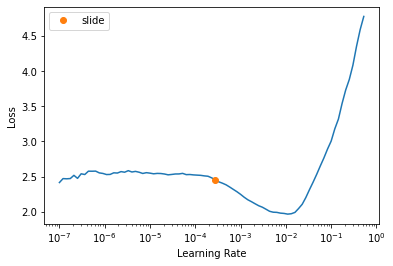

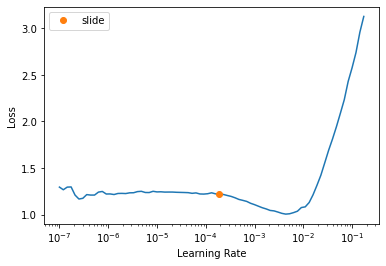

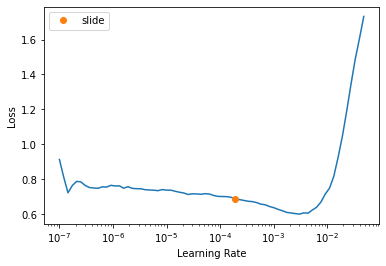

In [42]:
learner = create_reproducible_learner(resnet18,
                                      learner_kwargs=dict(cbs=None))
experiments.run_lr_find_experiment(learner,
                                   num_epochs_between_finds=5,
                                   num_finds=3,
                                   suggestion_method=SuggestionMethod.Slide,
                                   show_plot=True,
                                   disable_mlflow=True)

In [7]:
with mlflow.start_run(run_name='lr-finder-slide'):
    learner = create_reproducible_learner(
        resnet18,
        learner_kwargs=dict(cbs=experiments.MLflowCallback(run_name_prefix=f'initial fine tune - '))
    )
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    experiments.run_lr_find_experiment(learner,
                                       num_epochs_between_finds=10,
                                       num_finds=11,
                                       suggestion_method=SuggestionMethod.Slide)
    mlflow.log_metrics(experiments.get_learner_metrics_with_tta(learner, tta_prefix='tta_', beta=0))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,6.321728,5.460814,0.027027,0.054054,00:05


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,5.655921,4.805379,0.036036,0.063063,00:06
1,5.318436,4.397977,0.072072,0.171171,00:07
2,4.873107,3.897101,0.126126,0.252252,00:07
3,4.353020,3.470345,0.243243,0.387387,00:06
4,3.816802,3.221151,0.288288,0.441441,00:06
5,3.328401,3.035181,0.333333,0.486486,00:08
6,2.939669,2.932006,0.351351,0.486486,00:06
7,2.601890,2.858057,0.351351,0.495495,00:06
8,2.352452,2.839766,0.351351,0.495495,00:06
9,2.136343,2.835786,0.351351,0.513514,00:06


Next learning rate: 0.000229


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,1.158808,2.797883,0.351351,0.522523,00:07
1,1.034741,2.658238,0.351351,0.549550,00:08
2,0.955558,2.523207,0.405405,0.603604,00:07
3,0.880900,2.437670,0.414414,0.621622,00:07
4,0.794563,2.403067,0.378378,0.666667,00:07
5,0.718529,2.365593,0.387387,0.657658,00:07
6,0.667577,2.331189,0.387387,0.675676,00:07
7,0.612472,2.323287,0.369369,0.693694,00:07
8,0.571395,2.329534,0.369369,0.675676,00:07
9,0.539188,2.324488,0.378378,0.684685,00:07


Next learning rate: 0.000191


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.363861,2.319486,0.387387,0.675676,00:07
1,0.343679,2.287477,0.423423,0.657658,00:07
2,0.319751,2.210983,0.423423,0.720721,00:07
3,0.308669,2.213508,0.477477,0.720721,00:07
4,0.291056,2.222519,0.450450,0.693694,00:07
5,0.274750,2.189758,0.477477,0.702703,00:08
6,0.262790,2.165321,0.486486,0.720721,00:08
7,0.252054,2.143093,0.486486,0.738739,00:07
8,0.241447,2.143205,0.486486,0.729730,00:07
9,0.227311,2.139396,0.459459,0.738739,00:08


Next learning rate: 0.000275


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.173012,2.132161,0.477477,0.747748,00:07
1,0.171182,2.081371,0.468468,0.738739,00:07
2,0.163474,2.050029,0.495495,0.729730,00:07
3,0.158021,2.083844,0.522523,0.720721,00:07
4,0.154319,1.961166,0.558559,0.747748,00:07
5,0.146768,1.918086,0.522523,0.756757,00:07
6,0.139256,1.926851,0.549550,0.747748,00:07
7,0.132212,1.939690,0.549550,0.738739,00:07
8,0.128602,1.954926,0.531532,0.747748,00:08
9,0.125848,1.966207,0.531532,0.747748,00:08


Next learning rate: 0.000229


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.084523,1.976641,0.531532,0.738739,00:07
1,0.086362,1.963587,0.540541,0.756757,00:07
2,0.084540,1.994667,0.531532,0.729730,00:08
3,0.087815,1.995414,0.549550,0.738739,00:07
4,0.082432,1.943007,0.567568,0.729730,00:08
5,0.075276,1.914108,0.576577,0.747748,00:07
6,0.072891,1.906715,0.585586,0.747748,00:07
7,0.075227,1.892265,0.594595,0.747748,00:07
8,0.073187,1.894660,0.594595,0.747748,00:08
9,0.071896,1.884949,0.585586,0.747748,00:07


Next learning rate: 0.000158


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.063429,1.889602,0.585586,0.756757,00:07
1,0.061526,1.886597,0.567568,0.756757,00:08
2,0.051810,1.880132,0.567568,0.747748,00:08
3,0.049975,1.891740,0.558559,0.747748,00:07
4,0.050324,1.901045,0.549550,0.747748,00:08
5,0.049166,1.888469,0.558559,0.756757,00:08
6,0.046385,1.884172,0.549550,0.756757,00:07
7,0.043987,1.873170,0.549550,0.756757,00:07
8,0.042187,1.866989,0.558559,0.765766,00:07
9,0.043360,1.871316,0.576577,0.756757,00:08


Next learning rate: 0.000158


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.038408,1.859296,0.558559,0.774775,00:07
1,0.040969,1.849657,0.567568,0.765766,00:07
2,0.036666,1.838160,0.585586,0.765766,00:08
3,0.037323,1.864255,0.576577,0.765766,00:07
4,0.035622,1.892479,0.576577,0.756757,00:07
5,0.035983,1.884397,0.585586,0.756757,00:07
6,0.036647,1.884569,0.585586,0.783784,00:08
7,0.036496,1.881562,0.594595,0.774775,00:07
8,0.035963,1.886097,0.576577,0.765766,00:07
9,0.036062,1.877963,0.576577,0.765766,00:07


Next learning rate: 0.000110


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.024043,1.869490,0.576577,0.765766,00:08
1,0.031770,1.862237,0.585586,0.774775,00:07
2,0.030367,1.870692,0.549550,0.756757,00:07
3,0.029825,1.888666,0.558559,0.756757,00:08
4,0.029135,1.888869,0.585586,0.747748,00:07
5,0.030043,1.887991,0.594595,0.747748,00:07
6,0.029578,1.873096,0.594595,0.747748,00:07
7,0.028227,1.880645,0.567568,0.765766,00:07
8,0.026641,1.867125,0.576577,0.765766,00:07
9,0.026101,1.862830,0.585586,0.765766,00:07


Next learning rate: 0.000110


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.020055,1.857524,0.585586,0.765766,00:08
1,0.021246,1.842291,0.585586,0.756757,00:08
2,0.023551,1.909397,0.585586,0.765766,00:07
3,0.021968,1.984376,0.558559,0.756757,00:08
4,0.023650,1.978825,0.540541,0.738739,00:07
5,0.023822,1.945629,0.531532,0.765766,00:07
6,0.022548,1.905216,0.558559,0.765766,00:08
7,0.023526,1.895411,0.549550,0.774775,00:07
8,0.023717,1.895911,0.585586,0.774775,00:08
9,0.022704,1.893168,0.576577,0.774775,00:07


Next learning rate: 0.000091


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.021339,1.882368,0.585586,0.774775,00:08
1,0.019668,1.859497,0.585586,0.774775,00:08
2,0.020954,1.889991,0.531532,0.765766,00:07
3,0.020083,1.869301,0.540541,0.765766,00:08
4,0.020332,1.859530,0.558559,0.756757,00:08
5,0.019734,1.859029,0.549550,0.765766,00:07
6,0.019791,1.844006,0.567568,0.765766,00:07
7,0.019093,1.838272,0.567568,0.774775,00:07
8,0.018283,1.829072,0.576577,0.765766,00:08
9,0.017868,1.833711,0.576577,0.756757,00:07


Next learning rate: 0.000110


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.012798,1.829776,0.576577,0.765766,00:08
1,0.019767,1.840759,0.567568,0.747748,00:08
2,0.016993,1.819480,0.558559,0.756757,00:07
3,0.017174,1.829044,0.558559,0.756757,00:07
4,0.017312,1.839058,0.576577,0.738739,00:07
5,0.015344,1.843166,0.567568,0.756757,00:07
6,0.015065,1.814241,0.576577,0.765766,00:07
7,0.014496,1.794323,0.585586,0.774775,00:07
8,0.013514,1.790345,0.576577,0.765766,00:08
9,0.013484,1.796910,0.576577,0.774775,00:07


Next learning rate: 0.000091


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.010510,1.787644,0.576577,0.774775,00:08
1,0.010660,1.766606,0.567568,0.756757,00:08
2,0.011006,1.745262,0.603604,0.783784,00:07
3,0.011749,1.762742,0.576577,0.783784,00:07
4,0.012142,1.730875,0.603604,0.783784,00:07
5,0.011958,1.739092,0.603604,0.783784,00:08
6,0.012358,1.748102,0.612613,0.783784,00:07
7,0.012450,1.751731,0.621622,0.783784,00:08
8,0.012080,1.748027,0.603604,0.783784,00:07
9,0.011732,1.749549,0.594595,0.774775,00:07


In [8]:
with mlflow.start_run(run_name='lr-finder-minimum'):
    learner = create_reproducible_learner(
        resnet18,
        learner_kwargs=dict(cbs=experiments.MLflowCallback(run_name_prefix=f'initial fine tune - '))
    )
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    experiments.run_lr_find_experiment(learner,
                                       num_epochs_between_finds=10,
                                       num_finds=11,
                                       suggestion_method=SuggestionMethod.Minimum)
    mlflow.log_metrics(experiments.get_learner_metrics_with_tta(learner, tta_prefix='tta_', beta=0))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,6.321728,5.460814,0.027027,0.054054,00:06


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,5.655921,4.805379,0.036036,0.063063,00:06
1,5.318436,4.397977,0.072072,0.171171,00:06
2,4.873107,3.897101,0.126126,0.252252,00:07
3,4.353020,3.470345,0.243243,0.387387,00:07
4,3.816802,3.221151,0.288288,0.441441,00:07
5,3.328401,3.035181,0.333333,0.486486,00:07
6,2.939669,2.932006,0.351351,0.486486,00:07
7,2.601890,2.858057,0.351351,0.495495,00:07
8,2.352452,2.839766,0.351351,0.495495,00:07
9,2.136343,2.835786,0.351351,0.513514,00:08


Next learning rate: 0.000437


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,1.149830,2.764854,0.360360,0.531532,00:07
1,0.989068,2.596148,0.369369,0.558559,00:07
2,0.880273,2.491531,0.450450,0.630631,00:08
3,0.794083,2.522414,0.405405,0.603604,00:07
4,0.705103,2.413470,0.369369,0.630631,00:07
5,0.629638,2.316079,0.396396,0.666667,00:07
6,0.564370,2.290973,0.414414,0.648649,00:07
7,0.506040,2.267089,0.441441,0.666667,00:07
8,0.462540,2.254981,0.450450,0.675676,00:07
9,0.429032,2.253483,0.450450,0.675676,00:08


Next learning rate: 0.000251


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.263652,2.249867,0.459459,0.666667,00:07
1,0.253208,2.192171,0.441441,0.693694,00:08
2,0.233477,2.172436,0.450450,0.720721,00:08
3,0.216064,2.114049,0.486486,0.729730,00:07
4,0.203057,2.083533,0.513514,0.693694,00:07
5,0.192708,2.095505,0.468468,0.684685,00:07
6,0.186941,2.058306,0.486486,0.693694,00:07
7,0.178060,2.033317,0.513514,0.693694,00:08
8,0.164091,2.029546,0.513514,0.711712,00:07
9,0.154764,2.031255,0.495495,0.711712,00:07


Next learning rate: 0.000174


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.104151,2.017865,0.522523,0.702703,00:07
1,0.109154,1.998744,0.531532,0.729730,00:08
2,0.103361,1.985002,0.513514,0.738739,00:07
3,0.092857,1.982836,0.504505,0.747748,00:08
4,0.099407,1.977706,0.504505,0.756757,00:08
5,0.094832,1.962811,0.513514,0.765766,00:08
6,0.089304,1.956144,0.513514,0.756757,00:07
7,0.086275,1.945422,0.531532,0.747748,00:07
8,0.083838,1.937056,0.513514,0.765766,00:07
9,0.082832,1.936620,0.522523,0.765766,00:07


Next learning rate: 0.000000


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.064013,1.943968,0.513514,0.756757,00:07
1,0.070276,1.945198,0.522523,0.765766,00:08
2,0.066079,1.943784,0.522523,0.765766,00:07
3,0.068099,1.947030,0.522523,0.756757,00:08
4,0.069926,1.940573,0.531532,0.747748,00:07
5,0.068948,1.941556,0.522523,0.756757,00:07
6,0.066479,1.943246,0.522523,0.747748,00:08
7,0.065334,1.936022,0.504505,0.756757,00:07
8,0.065825,1.950822,0.513514,0.756757,00:07
9,0.068190,1.933159,0.504505,0.756757,00:07


Next learning rate: 0.000002


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.093734,1.937597,0.504505,0.747748,00:08
1,0.081494,1.939192,0.513514,0.756757,00:08
2,0.075524,1.936141,0.513514,0.756757,00:07
3,0.068138,1.934016,0.531532,0.756757,00:07
4,0.070160,1.943580,0.531532,0.756757,00:07
5,0.074427,1.940006,0.531532,0.756757,00:07
6,0.072378,1.938540,0.522523,0.747748,00:08
7,0.069211,1.939402,0.513514,0.756757,00:07
8,0.070369,1.946862,0.504505,0.747748,00:07
9,0.070885,1.949284,0.513514,0.756757,00:08


Next learning rate: 0.000120


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.084399,1.949513,0.522523,0.738739,00:07
1,0.073760,1.988392,0.531532,0.747748,00:08
2,0.065882,2.042946,0.477477,0.756757,00:07
3,0.064595,2.044417,0.504505,0.720721,00:07
4,0.061141,2.010176,0.540541,0.738739,00:07
5,0.059442,1.994324,0.540541,0.738739,00:08
6,0.058118,1.986566,0.558559,0.729730,00:07
7,0.058920,1.969543,0.558559,0.720721,00:07
8,0.056568,1.958401,0.558559,0.720721,00:07
9,0.054915,1.972839,0.558559,0.711712,00:08


Next learning rate: 0.000000


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.057608,1.963926,0.558559,0.720721,00:07
1,0.053192,1.960043,0.558559,0.720721,00:08
2,0.048850,1.958493,0.540541,0.720721,00:07
3,0.047475,1.961666,0.540541,0.720721,00:08
4,0.048589,1.967727,0.558559,0.720721,00:07
5,0.045835,1.958885,0.567568,0.711712,00:07
6,0.046353,1.970228,0.549550,0.702703,00:07
7,0.047426,1.971325,0.558559,0.720721,00:07
8,0.048847,1.971951,0.558559,0.711712,00:08
9,0.049993,1.970953,0.558559,0.711712,00:08


Next learning rate: 0.000000


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.053288,1.969743,0.549550,0.711712,00:07
1,0.048489,1.974101,0.549550,0.720721,00:07
2,0.048041,1.972978,0.549550,0.711712,00:07
3,0.052298,1.969014,0.549550,0.711712,00:08
4,0.054033,1.966394,0.540541,0.711712,00:08
5,0.051467,1.965396,0.549550,0.711712,00:07
6,0.049225,1.963299,0.558559,0.702703,00:07
7,0.049278,1.964136,0.558559,0.711712,00:07
8,0.049196,1.967658,0.567568,0.711712,00:08
9,0.047951,1.971436,0.558559,0.711712,00:07


Next learning rate: 0.000006


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.048164,1.975256,0.540541,0.702703,00:07
1,0.046253,1.958618,0.549550,0.729730,00:07
2,0.046310,1.957350,0.549550,0.720721,00:07
3,0.048314,1.954742,0.549550,0.747748,00:07
4,0.045320,1.954341,0.549550,0.747748,00:07
5,0.045188,1.953266,0.558559,0.738739,00:07
6,0.043861,1.960747,0.549550,0.729730,00:07
7,0.046679,1.956053,0.558559,0.729730,00:07
8,0.046405,1.960665,0.549550,0.729730,00:07
9,0.046991,1.957082,0.558559,0.729730,00:08


Next learning rate: 0.000000


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.050643,1.958032,0.576577,0.720721,00:08
1,0.046675,1.955101,0.567568,0.738739,00:08
2,0.047606,1.960118,0.549550,0.738739,00:07
3,0.046159,1.954797,0.558559,0.729730,00:07
4,0.045825,1.959895,0.558559,0.738739,00:07
5,0.047189,1.952466,0.558559,0.720721,00:07
6,0.046185,1.957584,0.567568,0.729730,00:07
7,0.047745,1.961305,0.567568,0.720721,00:07
8,0.045770,1.952320,0.567568,0.720721,00:07
9,0.045873,1.945267,0.558559,0.738739,00:07


Next learning rate: 0.000040


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.054806,1.937626,0.549550,0.747748,00:08
1,0.049886,1.928941,0.567568,0.747748,00:07
2,0.049325,1.936983,0.576577,0.729730,00:07
3,0.046790,1.911931,0.576577,0.729730,00:07
4,0.044321,1.912320,0.576577,0.729730,00:08
5,0.044049,1.928069,0.567568,0.747748,00:08
6,0.042513,1.932528,0.576577,0.738739,00:08
7,0.040979,1.929009,0.567568,0.747748,00:08
8,0.039642,1.933948,0.567568,0.747748,00:08
9,0.040316,1.928726,0.567568,0.747748,00:08


In [9]:
with mlflow.start_run(run_name='lr-finder-steep'):
    learner = create_reproducible_learner(
        resnet18,
        learner_kwargs=dict(cbs=experiments.MLflowCallback(run_name_prefix=f'initial fine tune - '))
    )
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    experiments.run_lr_find_experiment(learner,
                                       num_epochs_between_finds=10,
                                       num_finds=11,
                                       suggestion_method=SuggestionMethod.Steep)
    mlflow.log_metrics(experiments.get_learner_metrics_with_tta(learner, tta_prefix='tta_', beta=0))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,6.321728,5.460814,0.027027,0.054054,00:07


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,5.655921,4.805379,0.036036,0.063063,00:08
1,5.318436,4.397977,0.072072,0.171171,00:08
2,4.873107,3.897101,0.126126,0.252252,00:08
3,4.353020,3.470345,0.243243,0.387387,00:08
4,3.816802,3.221151,0.288288,0.441441,00:08
5,3.328401,3.035181,0.333333,0.486486,00:08
6,2.939669,2.932006,0.351351,0.486486,00:08
7,2.601890,2.858057,0.351351,0.495495,00:08
8,2.352452,2.839766,0.351351,0.495495,00:08
9,2.136343,2.835786,0.351351,0.513514,00:08


Next learning rate: 0.000832


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,1.134509,2.711318,0.351351,0.531532,00:08
1,0.927566,2.583562,0.369369,0.594595,00:08
2,0.815832,2.691023,0.369369,0.630631,00:08
3,0.745403,2.844549,0.306306,0.540541,00:08
4,0.671464,2.739064,0.297297,0.558559,00:08
5,0.605464,2.533461,0.360360,0.585586,00:08
6,0.542173,2.356169,0.432432,0.612613,00:07
7,0.477872,2.279391,0.450450,0.648649,00:08
8,0.431350,2.243750,0.450450,0.648649,00:08
9,0.393798,2.241000,0.450450,0.666667,00:08


Next learning rate: 0.000001


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.171275,2.233892,0.450450,0.666667,00:08
1,0.177596,2.233174,0.450450,0.657658,00:08
2,0.178944,2.229629,0.459459,0.675676,00:08
3,0.194535,2.226407,0.450450,0.657658,00:08
4,0.192018,2.231955,0.450450,0.657658,00:07
5,0.185419,2.233944,0.450450,0.666667,00:07
6,0.188310,2.229647,0.450450,0.648649,00:08
7,0.188886,2.232842,0.441441,0.657658,00:08
8,0.189655,2.237213,0.450450,0.666667,00:08
9,0.188545,2.224871,0.450450,0.657658,00:08


Next learning rate: 0.000001


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.187222,2.221093,0.450450,0.657658,00:08
1,0.189359,2.224126,0.450450,0.657658,00:08
2,0.184671,2.228755,0.441441,0.648649,00:08
3,0.188842,2.227467,0.441441,0.666667,00:08
4,0.195336,2.230427,0.450450,0.657658,00:08
5,0.191443,2.233720,0.459459,0.675676,00:08
6,0.198077,2.228551,0.459459,0.666667,00:08
7,0.204124,2.223785,0.459459,0.666667,00:08
8,0.203548,2.234824,0.450450,0.666667,00:08
9,0.200377,2.227920,0.459459,0.657658,00:08


Next learning rate: 0.000001


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.176147,2.239903,0.450450,0.657658,00:08
1,0.178774,2.230213,0.450450,0.666667,00:08
2,0.172332,2.231457,0.450450,0.666667,00:07
3,0.172759,2.226479,0.450450,0.666667,00:08
4,0.179697,2.235400,0.450450,0.657658,00:08
5,0.181882,2.228839,0.459459,0.657658,00:07
6,0.178425,2.218816,0.459459,0.657658,00:08
7,0.176515,2.216275,0.459459,0.657658,00:08
8,0.181321,2.221714,0.450450,0.666667,00:07
9,0.184355,2.226252,0.450450,0.648649,00:08


Next learning rate: 0.000001


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.205099,2.230747,0.450450,0.657658,00:08
1,0.180658,2.222302,0.459459,0.657658,00:07
2,0.183038,2.229142,0.450450,0.657658,00:08
3,0.179067,2.215564,0.441441,0.666667,00:08
4,0.180069,2.224131,0.450450,0.657658,00:08
5,0.184613,2.220659,0.450450,0.675676,00:08
6,0.182124,2.217548,0.459459,0.675676,00:08
7,0.184201,2.223760,0.450450,0.666667,00:08
8,0.189682,2.228404,0.450450,0.657658,00:08
9,0.183404,2.228338,0.450450,0.648649,00:08


Next learning rate: 0.000008


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.161556,2.227675,0.450450,0.657658,00:08
1,0.175821,2.213673,0.450450,0.657658,00:08
2,0.177774,2.201848,0.450450,0.657658,00:08
3,0.169101,2.194350,0.450450,0.657658,00:08
4,0.166859,2.182490,0.450450,0.675676,00:08
5,0.162645,2.175767,0.450450,0.657658,00:08
6,0.163517,2.177603,0.450450,0.648649,00:08
7,0.159029,2.172330,0.450450,0.648649,00:08
8,0.157716,2.173414,0.450450,0.657658,00:08
9,0.160077,2.191445,0.450450,0.657658,00:08


Next learning rate: 0.000007


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.193303,2.177976,0.450450,0.666667,00:08
1,0.183829,2.174679,0.450450,0.666667,00:08
2,0.170688,2.167844,0.450450,0.657658,00:08
3,0.158410,2.160800,0.450450,0.657658,00:07
4,0.159630,2.156271,0.459459,0.657658,00:08
5,0.156436,2.154231,0.459459,0.657658,00:08
6,0.156504,2.160253,0.450450,0.657658,00:08
7,0.156565,2.155500,0.459459,0.657658,00:08
8,0.147858,2.136640,0.468468,0.657658,00:08
9,0.144982,2.141121,0.459459,0.657658,00:08


Next learning rate: 0.000001


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.130837,2.149113,0.468468,0.657658,00:08
1,0.147631,2.150173,0.459459,0.657658,00:08
2,0.149008,2.149063,0.459459,0.657658,00:08
3,0.137665,2.153220,0.450450,0.657658,00:08
4,0.132195,2.153806,0.450450,0.657658,00:08
5,0.133942,2.146787,0.450450,0.657658,00:08
6,0.140122,2.143759,0.450450,0.657658,00:08
7,0.136093,2.138301,0.459459,0.657658,00:08
8,0.134431,2.146499,0.459459,0.657658,00:08
9,0.139750,2.151469,0.468468,0.657658,00:08


Next learning rate: 0.000002


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.159010,2.148790,0.459459,0.666667,00:08
1,0.157636,2.145783,0.468468,0.657658,00:08
2,0.164608,2.139700,0.468468,0.657658,00:08
3,0.155469,2.151904,0.459459,0.657658,00:08
4,0.153862,2.153541,0.450450,0.657658,00:08
5,0.152358,2.150383,0.450450,0.657658,00:08
6,0.151665,2.144260,0.459459,0.657658,00:08
7,0.155962,2.145095,0.459459,0.657658,00:08
8,0.151425,2.145281,0.459459,0.657658,00:08
9,0.148548,2.140186,0.468468,0.666667,00:08


Next learning rate: 0.000005


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.144181,2.142843,0.459459,0.657658,00:08
1,0.138123,2.136230,0.459459,0.666667,00:08
2,0.138276,2.141650,0.468468,0.666667,00:08
3,0.136731,2.126876,0.459459,0.666667,00:08
4,0.133825,2.120389,0.468468,0.657658,00:08
5,0.132493,2.116918,0.459459,0.657658,00:08
6,0.130623,2.108534,0.468468,0.657658,00:08
7,0.129107,2.118923,0.477477,0.666667,00:08
8,0.129681,2.120066,0.459459,0.657658,00:07
9,0.131461,2.116882,0.468468,0.666667,00:08


Next learning rate: 0.000001


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.113349,2.117832,0.468468,0.666667,00:08
1,0.121798,2.119835,0.468468,0.666667,00:08
2,0.135913,2.114616,0.468468,0.666667,00:08
3,0.134801,2.116445,0.468468,0.666667,00:08
4,0.134073,2.120812,0.477477,0.666667,00:08
5,0.130041,2.125117,0.468468,0.666667,00:08
6,0.132727,2.117636,0.477477,0.666667,00:08
7,0.127304,2.123424,0.477477,0.657658,00:08
8,0.127651,2.114346,0.477477,0.666667,00:08
9,0.125667,2.114693,0.477477,0.666667,00:08


In [10]:
with mlflow.start_run(run_name='lr-finder-valley'):
    learner = create_reproducible_learner(
        resnet18,
        learner_kwargs=dict(cbs=experiments.MLflowCallback(run_name_prefix=f'initial fine tune - '))
    )
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    experiments.run_lr_find_experiment(learner,
                                       num_epochs_between_finds=10,
                                       num_finds=11,
                                       suggestion_method=SuggestionMethod.Valley)
    mlflow.log_metrics(experiments.get_learner_metrics_with_tta(learner, tta_prefix='tta_', beta=0))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,6.321728,5.460814,0.027027,0.054054,00:07


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,5.655921,4.805379,0.036036,0.063063,00:08
1,5.318436,4.397977,0.072072,0.171171,00:08
2,4.873107,3.897101,0.126126,0.252252,00:08
3,4.353020,3.470345,0.243243,0.387387,00:08
4,3.816802,3.221151,0.288288,0.441441,00:08
5,3.328401,3.035181,0.333333,0.486486,00:08
6,2.939669,2.932006,0.351351,0.486486,00:08
7,2.601890,2.858057,0.351351,0.495495,00:07
8,2.352452,2.839766,0.351351,0.495495,00:08
9,2.136343,2.835786,0.351351,0.513514,00:08


Next learning rate: 0.000158


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,1.161890,2.809365,0.351351,0.522523,00:08
1,1.053117,2.700716,0.333333,0.549550,00:08
2,0.990556,2.569516,0.369369,0.585586,00:07
3,0.933128,2.474480,0.387387,0.621622,00:08
4,0.854640,2.417896,0.378378,0.630631,00:08
5,0.779793,2.407791,0.360360,0.657658,00:08
6,0.730947,2.393788,0.324324,0.657658,00:08
7,0.684733,2.381861,0.342342,0.666667,00:08
8,0.649099,2.392047,0.342342,0.639640,00:08
9,0.616703,2.386695,0.342342,0.639640,00:08


Next learning rate: 0.000331


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.467036,2.379446,0.396396,0.639640,00:08
1,0.444186,2.338433,0.414414,0.666667,00:08
2,0.415715,2.229888,0.441441,0.666667,00:08
3,0.398163,2.220798,0.477477,0.693694,00:08
4,0.363160,2.255079,0.477477,0.657658,00:08
5,0.338755,2.244612,0.459459,0.639640,00:08
6,0.315796,2.212758,0.477477,0.657658,00:08
7,0.294570,2.210131,0.459459,0.657658,00:07
8,0.271299,2.210439,0.459459,0.657658,00:08
9,0.252752,2.208267,0.468468,0.648649,00:08


Next learning rate: 0.000158


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.190877,2.216982,0.450450,0.648649,00:08
1,0.165438,2.176259,0.450450,0.675676,00:07
2,0.154741,2.133615,0.459459,0.666667,00:08
3,0.145429,2.116167,0.495495,0.675676,00:07
4,0.139084,2.082243,0.522523,0.702703,00:08
5,0.133133,2.079296,0.522523,0.702703,00:08
6,0.131230,2.062222,0.540541,0.693694,00:08
7,0.128470,2.049382,0.531532,0.693694,00:08
8,0.124786,2.041610,0.522523,0.693694,00:08
9,0.119190,2.040282,0.522523,0.693694,00:08


Next learning rate: 0.000398


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.100153,2.040442,0.531532,0.684685,00:08
1,0.100762,2.005473,0.549550,0.711712,00:08
2,0.096067,2.016293,0.504505,0.693694,00:08
3,0.096963,1.992397,0.549550,0.729730,00:09
4,0.092635,1.987068,0.558559,0.720721,00:08
5,0.093163,1.967402,0.549550,0.720721,00:08
6,0.089868,1.980147,0.567568,0.720721,00:09
7,0.087568,1.984738,0.576577,0.693694,00:08
8,0.085167,1.968056,0.594595,0.711712,00:08
9,0.078713,1.972417,0.594595,0.711712,00:08


Next learning rate: 0.000479


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.073136,1.964205,0.612613,0.711712,00:08
1,0.065065,1.991633,0.576577,0.738739,00:08
2,0.058308,2.069209,0.540541,0.720721,00:08
3,0.056437,2.046755,0.531532,0.711712,00:08
4,0.056165,2.027416,0.549550,0.711712,00:08
5,0.055695,2.011401,0.585586,0.693694,00:08
6,0.053551,2.046488,0.540541,0.711712,00:08
7,0.053388,2.024544,0.540541,0.711712,00:08
8,0.052250,2.014376,0.549550,0.729730,00:08
9,0.050855,1.997160,0.576577,0.738739,00:08


Next learning rate: 0.000275


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.046454,1.978126,0.567568,0.747748,00:09
1,0.054145,1.974730,0.549550,0.747748,00:08
2,0.047893,1.945498,0.567568,0.738739,00:08
3,0.045205,1.958327,0.594595,0.729730,00:08
4,0.041327,1.956119,0.567568,0.738739,00:08
5,0.038914,1.920176,0.576577,0.738739,00:08
6,0.036414,1.898012,0.576577,0.756757,00:08
7,0.034286,1.905517,0.567568,0.756757,00:08
8,0.033214,1.906116,0.576577,0.765766,00:08
9,0.031637,1.896706,0.576577,0.756757,00:08


Next learning rate: 0.000229


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.027876,1.896963,0.594595,0.756757,00:08
1,0.024491,1.896837,0.576577,0.738739,00:08
2,0.024312,1.945789,0.585586,0.702703,00:08
3,0.023438,1.981705,0.558559,0.711712,00:07
4,0.023607,1.971189,0.567568,0.711712,00:08
5,0.022055,1.981623,0.558559,0.720721,00:08
6,0.021278,1.975228,0.549550,0.738739,00:08
7,0.020085,1.961786,0.558559,0.720721,00:08
8,0.018760,1.959488,0.558559,0.720721,00:08
9,0.018076,1.954445,0.549550,0.738739,00:08


Next learning rate: 0.000398


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.032702,1.952076,0.558559,0.729730,00:08
1,0.025320,1.931373,0.585586,0.747748,00:08
2,0.022919,2.009821,0.531532,0.738739,00:08
3,0.024584,2.012927,0.540541,0.729730,00:08
4,0.030182,2.260589,0.459459,0.729730,00:08
5,0.033064,2.105269,0.495495,0.711712,00:08
6,0.035842,2.197150,0.513514,0.711712,00:08
7,0.039274,2.148719,0.486486,0.711712,00:08
8,0.038697,2.089861,0.477477,0.738739,00:08
9,0.036071,2.072462,0.504505,0.729730,00:08


Next learning rate: 0.000275


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.027414,2.050529,0.522523,0.720721,00:08
1,0.024380,2.004899,0.567568,0.738739,00:08
2,0.022081,1.974134,0.558559,0.747748,00:08
3,0.021714,2.064478,0.513514,0.729730,00:08
4,0.021431,2.059080,0.468468,0.738739,00:08
5,0.021945,2.026335,0.531532,0.729730,00:08
6,0.020958,2.045401,0.531532,0.729730,00:08
7,0.020020,2.031019,0.549550,0.738739,00:08
8,0.019600,2.009495,0.540541,0.738739,00:08
9,0.019404,2.011897,0.531532,0.747748,00:08


Next learning rate: 0.000158


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.015279,1.985256,0.549550,0.738739,00:08
1,0.013422,1.918174,0.576577,0.738739,00:08
2,0.012321,1.908533,0.567568,0.774775,00:08
3,0.013350,1.996127,0.513514,0.738739,00:08
4,0.012699,1.991254,0.540541,0.738739,00:08
5,0.012247,1.954347,0.531532,0.738739,00:08
6,0.011619,1.910615,0.549550,0.747748,00:08
7,0.012059,1.891760,0.549550,0.747748,00:08
8,0.011464,1.891991,0.549550,0.747748,00:08
9,0.011004,1.891052,0.549550,0.738739,00:08


Next learning rate: 0.000158


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,0.013378,1.873574,0.558559,0.747748,00:08
1,0.009723,1.834360,0.576577,0.747748,00:08
2,0.009123,1.791823,0.585586,0.765766,00:08
3,0.008421,1.808465,0.567568,0.765766,00:08
4,0.007897,1.837546,0.567568,0.756757,00:08
5,0.007531,1.848424,0.585586,0.765766,00:08
6,0.006961,1.855503,0.576577,0.774775,00:08
7,0.006735,1.849345,0.576577,0.774775,00:08
8,0.006367,1.845212,0.567568,0.774775,00:08
9,0.006140,1.848922,0.576577,0.783784,00:08


### MixUp with label smoothing

In [7]:
with mlflow.start_run(run_name='label-smoothing-mixup-lr-finder-slide'):
    learner = create_reproducible_learner(
        resnet18,
        learner_kwargs=dict(loss_func=LabelSmoothingCrossEntropy(),
                            cbs=[experiments.MLflowCallback(run_name_prefix=f'initial fine tune - '),
                                 MixUp()])
    )
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    mlflow.log_param('loss_func', 'LabelSmoothingCrossEntropy()')
    mlflow.log_param('cbs', 'MixUp()')

    experiments.run_lr_find_experiment(learner,
                                       num_epochs_between_finds=10,
                                       num_finds=11,
                                       suggestion_method=SuggestionMethod.Slide)

    mlflow.log_metrics(experiments.get_learner_metrics_with_tta(learner, tta_prefix='tta_', beta=0))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,6.428027,5.544185,0.036036,0.054054,00:05


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,5.784281,4.941432,0.036036,0.090090,00:06
1,5.686387,4.662886,0.054054,0.117117,00:07
2,5.477710,4.229248,0.072072,0.225225,00:06
3,5.164287,3.820616,0.153153,0.279279,00:06
4,4.860047,3.590598,0.225225,0.396396,00:07
5,4.552032,3.403672,0.270270,0.459459,00:07
6,4.272053,3.266332,0.342342,0.486486,00:07
7,4.065476,3.204499,0.378378,0.513514,00:07
8,3.899130,3.183727,0.351351,0.531532,00:07
9,3.769552,3.184872,0.351351,0.513514,00:06


Next learning rate: 0.000275


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.185551,3.154932,0.378378,0.540541,00:07
1,3.048266,3.046231,0.387387,0.531532,00:07
2,2.945401,3.021416,0.378378,0.567568,00:07
3,2.907580,2.973098,0.360360,0.576577,00:07
4,2.872212,2.872251,0.369369,0.585586,00:07
5,2.810856,2.829086,0.396396,0.558559,00:08
6,2.765980,2.809098,0.414414,0.585586,00:07
7,2.698854,2.777278,0.432432,0.621622,00:07
8,2.673981,2.762266,0.423423,0.612613,00:07
9,2.651344,2.758281,0.423423,0.621622,00:07


Next learning rate: 0.000229


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.532618,2.738721,0.414414,0.630631,00:07
1,2.525038,2.689342,0.423423,0.648649,00:07
2,2.497238,2.615885,0.423423,0.684685,00:07
3,2.476408,2.587765,0.423423,0.729730,00:07
4,2.472168,2.617023,0.441441,0.693694,00:07
5,2.454957,2.578194,0.486486,0.711712,00:07
6,2.419172,2.569606,0.477477,0.702703,00:07
7,2.400944,2.568928,0.486486,0.693694,00:07
8,2.396015,2.570065,0.486486,0.693694,00:07
9,2.388241,2.576718,0.477477,0.675676,00:07


Next learning rate: 0.000132


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.370541,2.561406,0.486486,0.702703,00:08
1,2.381273,2.552339,0.477477,0.729730,00:07
2,2.329553,2.585500,0.495495,0.702703,00:07
3,2.338232,2.584585,0.450450,0.693694,00:07
4,2.324836,2.542563,0.459459,0.693694,00:08
5,2.318463,2.529407,0.477477,0.693694,00:07
6,2.321317,2.518025,0.495495,0.711712,00:08
7,2.307965,2.510511,0.504505,0.702703,00:07
8,2.295489,2.495751,0.486486,0.720721,00:07
9,2.296592,2.498043,0.495495,0.729730,00:07


Next learning rate: 0.000132


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.233909,2.502068,0.486486,0.738739,00:08
1,2.270227,2.498739,0.495495,0.720721,00:07
2,2.219753,2.504416,0.495495,0.738739,00:07
3,2.240008,2.518505,0.495495,0.711712,00:07
4,2.238818,2.513069,0.486486,0.729730,00:07
5,2.233705,2.510645,0.504505,0.729730,00:07
6,2.239221,2.539296,0.486486,0.702703,00:07
7,2.224623,2.548131,0.486486,0.702703,00:07
8,2.223819,2.562138,0.468468,0.684685,00:07
9,2.238508,2.564037,0.468468,0.702703,00:07


Next learning rate: 0.000132


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.302802,2.555385,0.486486,0.684685,00:07
1,2.285471,2.559386,0.468468,0.702703,00:07
2,2.240900,2.562444,0.504505,0.702703,00:07
3,2.219490,2.553102,0.495495,0.684685,00:07
4,2.240586,2.540167,0.495495,0.675676,00:07
5,2.241130,2.568623,0.486486,0.639640,00:07
6,2.244249,2.554467,0.486486,0.666667,00:07
7,2.232459,2.536069,0.477477,0.675676,00:07
8,2.225126,2.531897,0.468468,0.666667,00:07
9,2.213103,2.528077,0.477477,0.657658,00:07


Next learning rate: 0.000132


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.270809,2.524367,0.468468,0.666667,00:07
1,2.176294,2.564768,0.477477,0.675676,00:07
2,2.174754,2.608655,0.468468,0.684685,00:07
3,2.142025,2.617033,0.459459,0.711712,00:07
4,2.164054,2.658630,0.441441,0.657658,00:07
5,2.177816,2.682601,0.459459,0.675676,00:07
6,2.174416,2.675370,0.459459,0.675676,00:07
7,2.174558,2.655158,0.441441,0.684685,00:07
8,2.177588,2.638676,0.459459,0.675676,00:07
9,2.175758,2.641555,0.450450,0.675676,00:07


Next learning rate: 0.000132


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.210983,2.641122,0.441441,0.675676,00:08
1,2.204120,2.593262,0.459459,0.729730,00:07
2,2.186155,2.600523,0.477477,0.693694,00:07
3,2.206423,2.621711,0.468468,0.702703,00:07
4,2.222301,2.622279,0.468468,0.702703,00:07
5,2.207639,2.616871,0.441441,0.675676,00:07
6,2.192870,2.595721,0.477477,0.675676,00:07
7,2.201184,2.592349,0.468468,0.693694,00:07
8,2.205046,2.578055,0.468468,0.693694,00:07
9,2.206783,2.561369,0.468468,0.702703,00:07


Next learning rate: 0.000132


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.190160,2.570738,0.477477,0.711712,00:08
1,2.166484,2.563431,0.495495,0.711712,00:07
2,2.162076,2.597071,0.468468,0.711712,00:07
3,2.150468,2.643140,0.450450,0.684685,00:07
4,2.152697,2.639504,0.432432,0.684685,00:07
5,2.142938,2.614395,0.468468,0.675676,00:07
6,2.163124,2.600096,0.468468,0.684685,00:07
7,2.156090,2.586938,0.477477,0.693694,00:07
8,2.157222,2.572592,0.468468,0.693694,00:07
9,2.150820,2.572662,0.477477,0.684685,00:07


Next learning rate: 0.000132


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.146372,2.571011,0.468468,0.675676,00:08
1,2.136643,2.565634,0.495495,0.693694,00:07
2,2.190565,2.546601,0.513514,0.702703,00:07
3,2.162060,2.494596,0.504505,0.720721,00:07
4,2.150914,2.485250,0.495495,0.756757,00:07
5,2.137734,2.473798,0.504505,0.729730,00:07
6,2.149958,2.488011,0.504505,0.711712,00:07
7,2.154408,2.490240,0.468468,0.720721,00:07
8,2.140019,2.481661,0.477477,0.693694,00:07
9,2.136274,2.477531,0.486486,0.693694,00:07


Next learning rate: 0.000229


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.088692,2.477411,0.486486,0.702703,00:08
1,2.112990,2.489381,0.459459,0.720721,00:07
2,2.089683,2.585383,0.522523,0.711712,00:07
3,2.103158,2.535303,0.531532,0.675676,00:07
4,2.118738,2.549285,0.486486,0.693694,00:08
5,2.137534,2.571645,0.459459,0.675676,00:07
6,2.138474,2.548639,0.459459,0.693694,00:07
7,2.147857,2.524384,0.486486,0.702703,00:07
8,2.145893,2.532919,0.495495,0.702703,00:07
9,2.161885,2.540234,0.486486,0.711712,00:07


Next learning rate: 0.000132


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.208995,2.530241,0.486486,0.711712,00:08
1,2.186069,2.502756,0.513514,0.711712,00:07
2,2.151188,2.546590,0.522523,0.711712,00:07
3,2.130727,2.596215,0.486486,0.693694,00:07
4,2.136240,2.631898,0.450450,0.702703,00:07
5,2.120309,2.626526,0.486486,0.684685,00:07
6,2.120531,2.620016,0.486486,0.711712,00:07
7,2.127657,2.596077,0.495495,0.693694,00:07
8,2.120526,2.587106,0.495495,0.693694,00:07
9,2.116281,2.587401,0.486486,0.684685,00:07


In [23]:
with mlflow.start_run(run_name='label-smoothing-mixup-fine-tuned'):
    learner = create_reproducible_learner(
        resnet18,
        learner_kwargs=dict(loss_func=LabelSmoothingCrossEntropy(),
                            cbs=[experiments.MLflowCallback(), MixUp()])
    )
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    mlflow.log_param('loss_func', 'LabelSmoothingCrossEntropy()')
    mlflow.log_param('cbs', 'MixUp()')

    learner.fine_tune(120)

    mlflow.log_metrics(experiments.get_learner_metrics_with_tta(learner, tta_prefix='tta_', beta=0))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,6.428027,5.544185,0.036036,0.054054,00:05


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,5.787079,4.965166,0.036036,0.072072,00:06
1,5.734990,4.824654,0.045045,0.099099,00:06
2,5.661977,4.691018,0.054054,0.108108,00:06
3,5.543762,4.568211,0.063063,0.108108,00:07
4,5.442570,4.446495,0.063063,0.135135,00:06
5,5.311471,4.317885,0.072072,0.180180,00:07
6,5.154696,4.183697,0.090090,0.225225,00:07
7,5.028660,4.055230,0.135135,0.243243,00:07
8,4.894306,3.926062,0.171171,0.297297,00:07
9,4.763367,3.805897,0.189189,0.297297,00:07


SuggestedLRs(valley=1.3182567499825382e-06)

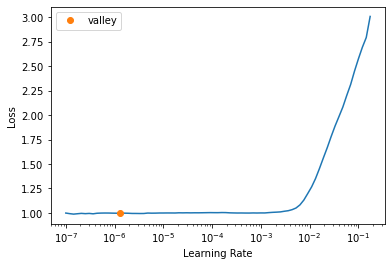

In [24]:
learner.remove_cb(MixUp)
learner.remove_cb(experiments.MLflowCallback)
learner.lr_find()

In [25]:
with mlflow.start_run(run_name='label-smoothing-mixup-fine-tuned-more-fine-tuning'):
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    mlflow.log_param('loss_func', 'LabelSmoothingCrossEntropy()')
    mlflow.log_param('cbs', 'MixUp()')
    mlflow.log_param('start_learner', 'label-smoothing-mixup-fine-tuned')
    mlflow.log_param('fine_tuned_epochs', 120)

    learner.add_cb(MixUp())
    learner.add_cb(experiments.MLflowCallback())
    
    learner.fine_tune(80, base_lr=1.32e-6)

    mlflow.log_metrics(experiments.get_learner_metrics_with_tta(learner, tta_prefix='tta_', beta=0))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,1.878291,2.504339,0.558559,0.684685,00:06


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,1.861770,2.504721,0.540541,0.675676,00:06
1,1.861355,2.501631,0.540541,0.702703,00:06
2,1.889007,2.502809,0.549550,0.702703,00:06
3,1.901075,2.505703,0.540541,0.702703,00:06
4,1.907419,2.513060,0.531532,0.693694,00:07
5,1.903816,2.513852,0.540541,0.702703,00:07
6,1.901256,2.515043,0.549550,0.693694,00:07
7,1.898763,2.507105,0.549550,0.693694,00:06
8,1.901183,2.508436,0.540541,0.684685,00:07
9,1.898390,2.516607,0.549550,0.684685,00:07


SuggestedLRs(slide=0.00015848931798245758, valley=9.120108734350652e-05)

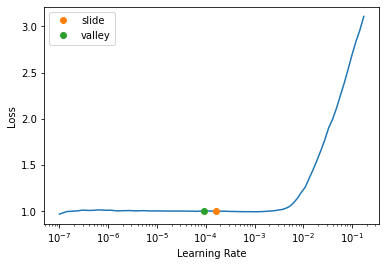

In [26]:
learner.remove_cb(MixUp)
learner.remove_cb(experiments.MLflowCallback)
learner.lr_find(suggest_funcs=[SuggestionMethod.Slide, SuggestionMethod.Valley])

In [27]:
with mlflow.start_run(run_name='label-smoothing-mixup-fine-tuned-even-more-fine-tuning'):
    mlflow.log_param('model', learner.arch.__name__)
    mlflow.log_param('item_tfms', 'RandomResizedCrop(224, min_scale=0.5)')
    mlflow.log_param('batch_tfms', 'aug_transforms()')
    mlflow.log_param('loss_func', 'LabelSmoothingCrossEntropy()')
    mlflow.log_param('cbs', 'MixUp()')
    mlflow.log_param('start_learner', 'label-smoothing-mixup-fine-tuned')
    mlflow.log_param('fine_tuned_epochs', 200)

    learner.add_cb(MixUp())
    learner.add_cb(experiments.MLflowCallback())
    
    learner.fine_tune(100, base_lr=0.00016)

    mlflow.log_metrics(experiments.get_learner_metrics_with_tta(learner, tta_prefix='tta_', beta=0))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,1.910001,2.494458,0.540541,0.702703,00:05


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,1.880701,2.506488,0.540541,0.702703,00:06
1,1.865980,2.500483,0.558559,0.702703,00:06
2,1.900137,2.505840,0.549550,0.693694,00:06
3,1.897595,2.501642,0.549550,0.684685,00:06
4,1.906035,2.504483,0.549550,0.684685,00:07
5,1.907517,2.511446,0.549550,0.675676,00:06
6,1.899333,2.508010,0.549550,0.702703,00:07
7,1.892217,2.508700,0.558559,0.684685,00:07
8,1.890655,2.506208,0.549550,0.675676,00:07
9,1.889481,2.501966,0.549550,0.693694,00:06
